#### Download manifest from GDC and parsing clincal XML

In [2]:
import os
import sys
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

script_path = os.path.abspath("../scripts")
if script_path not in sys.path:
    sys.path.append(script_path)

    
from build_tcga_anndata import (
    fetch_mapping_from_manifest,
    merge_counts_with_mapping,
    parse_clinical_xml,
    match_and_save
)
from download_tcga_data import (
    query_gdc_files,
    download_manifest,
    run_gdc_client
)
from annotate_gene_sequences import annotate_sequences_to_adata

#### Download data + Mapping

In [ ]:
tcga_projects = ["TCGA-BRCA", "TCGA-LUAD", "TCGA-LUSC"]

for project in tcga_projects:
    raw_dir = f"../data/raw/{project}"
    os.makedirs(f"{raw_dir}/HTSeq-Counts", exist_ok=True)
    os.makedirs(f"{raw_dir}/Clinical", exist_ok=True)

    # 1. download Expression 
    expr_ids = query_gdc_files(
        project, "Transcriptome Profiling",
        "Gene Expression Quantification", "STAR - Counts"
    )
    expr_manifest = f"{raw_dir}/expr_manifest.txt"
    download_manifest(expr_ids, expr_manifest)
    run_gdc_client(expr_manifest, f"{raw_dir}/HTSeq-Counts")

    # 2. download Clinical
    clin_ids = query_gdc_files(project, "Clinical", "Clinical Supplement")
    clin_manifest = f"{raw_dir}/clin_manifest.txt"
    download_manifest(clin_ids, clin_manifest)
    run_gdc_client(clin_manifest, f"{raw_dir}/Clinical")

    # 3. mapping UUID ↔ barcode
    mapping_csv = f"{raw_dir}/uuid2tcga.csv"
    mapping = fetch_mapping_from_manifest(expr_manifest, mapping_csv)

    # 4. Merge count
    count_csv = f"../data/processed/tcga/{project}_count_matrix.csv"
    merge_counts_with_mapping(f"{raw_dir}/HTSeq-Counts", mapping, count_csv)

    # 5. Merge Clinical XML 
    clin_csv = f"../data/processed/tcga/{project}_clinical_metadata.csv"
    parse_clinical_xml(f"{raw_dir}/Clinical", clin_csv)

    # 6. Mapping gene symbol & Store AnnData
    output_h5ad = f"../data/processed/tcga/{project}_23.h5ad"
    gene_map_csv = "../data/gencode/gene_id_to_symbol_brca.csv"  # 
    match_and_save(count_csv, clin_csv, gene_map_csv, output_h5ad)


#### add sequence in .var based on GENCODE(FASTA)

In [ ]:
fasta_path = "../data/gencode/gencode.v43.pc_transcripts.fa.gz"

for project in tcga_projects:
    input_h5ad = f"../data/processed/tcga/{project}_23.h5ad"
    output_h5ad = f"../data/processed/tcga/{project}_with_seq.h5ad"
    annotate_sequences_to_adata(input_h5ad, fasta_path, output_h5ad)

#### Inspect the structure of the dataset

In [14]:
tcga_projects = ["TCGA-BRCA", "TCGA-LUAD", "TCGA-LUSC"]
def inspect_dataset(name, adata):
    print(f"\n {name} | {adata.n_obs} samples × {adata.n_vars} genes")
    print(".obs columns:", adata.obs.columns.tolist())
    print(".var columns:", adata.var.columns.tolist())
    print("Missing sequences:", adata.var['sequence'].isna().sum())

    # .obs preview
    display(adata.obs.head())
    # .var preview
    display(adata.var[["gene_symbol", "transcript_id", "sequence"]].head())

for project in tcga_projects:
    path = f"../data/archive/{project}_with_seq.h5ad"
    adata = sc.read_h5ad(path)
    inspect_dataset(project, adata)


 TCGA-BRCA | 644 samples × 60664 genes
.obs columns: ['gender', 'age', 'vital_status', 'tumor_stage', 'batch']
.var columns: ['gene_id_x', 'gene_symbol', 'gene_id_y', 'gene_symbol_from_fasta', 'transcript_id', 'sequence']
Missing sequences: 0


,gender,age,vital_status,tumor_stage,batch
TCGA-3C-AAAU,FEMALE,55.0,Alive,Stage X,3C
TCGA-3C-AALI,FEMALE,50.0,Alive,Stage IIB,3C
TCGA-3C-AALJ,FEMALE,62.0,Alive,Stage IIB,3C
TCGA-3C-AALK,FEMALE,52.0,Alive,Stage IA,3C
TCGA-4H-AAAK,FEMALE,50.0,Alive,Stage IIIA,4H


,gene_symbol,transcript_id,sequence
gene_id_clean,,,
N_unmapped,NaN,,
N_multimapping,NaN,,
N_noFeature,NaN,,
N_ambiguous,NaN,,
ENSG00000000003,TSPAN6,ENST00000373020,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...



 TCGA-LUAD | 418 samples × 60664 genes
.obs columns: ['gender', 'age', 'vital_status', 'tumor_stage', 'batch']
.var columns: ['gene_symbol', 'gene_id', 'gene_symbol_from_fasta', 'transcript_id', 'sequence']
Missing sequences: 0


,gender,age,vital_status,tumor_stage,batch
TCGA-05-4244,MALE,70.0,Alive,Stage IV,05
TCGA-05-4249,MALE,67.0,Alive,Stage IB,05
TCGA-05-4250,FEMALE,79.0,Dead,Stage IIIA,05
TCGA-05-4389,MALE,70.0,Alive,Stage IA,05
TCGA-05-4390,FEMALE,58.0,Alive,Stage IB,05


,gene_symbol,transcript_id,sequence
gene_id_clean,,,
N_unmapped,NaN,,
N_multimapping,NaN,,
N_noFeature,NaN,,
N_ambiguous,NaN,,
ENSG00000000003,TSPAN6,ENST00000373020,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...



 TCGA-LUSC | 374 samples × 60664 genes
.obs columns: ['gender', 'age', 'vital_status', 'tumor_stage', 'batch']
.var columns: ['gene_symbol', 'gene_id', 'gene_symbol_from_fasta', 'transcript_id', 'sequence']
Missing sequences: 0


,gender,age,vital_status,tumor_stage,batch
TCGA-18-3411,FEMALE,63.0,Alive,Stage IIIA,18
TCGA-18-3412,MALE,52.0,Dead,Stage IB,18
TCGA-18-3414,MALE,73.0,Dead,Stage IV,18
TCGA-18-3415,MALE,77.0,Dead,Stage IB,18
TCGA-18-3417,MALE,65.0,Dead,Stage IV,18


,gene_symbol,transcript_id,sequence
gene_id_clean,,,
N_unmapped,NaN,,
N_multimapping,NaN,,
N_noFeature,NaN,,
N_ambiguous,NaN,,
ENSG00000000003,TSPAN6,ENST00000373020,AGTTGTGGACGCTCGTAAGTTTTCGGCAGTTTCCGGGGAGACTCGG...


### Add normalization: log2(RPM + 1)


[INFO] Processing TCGA-BRCA...


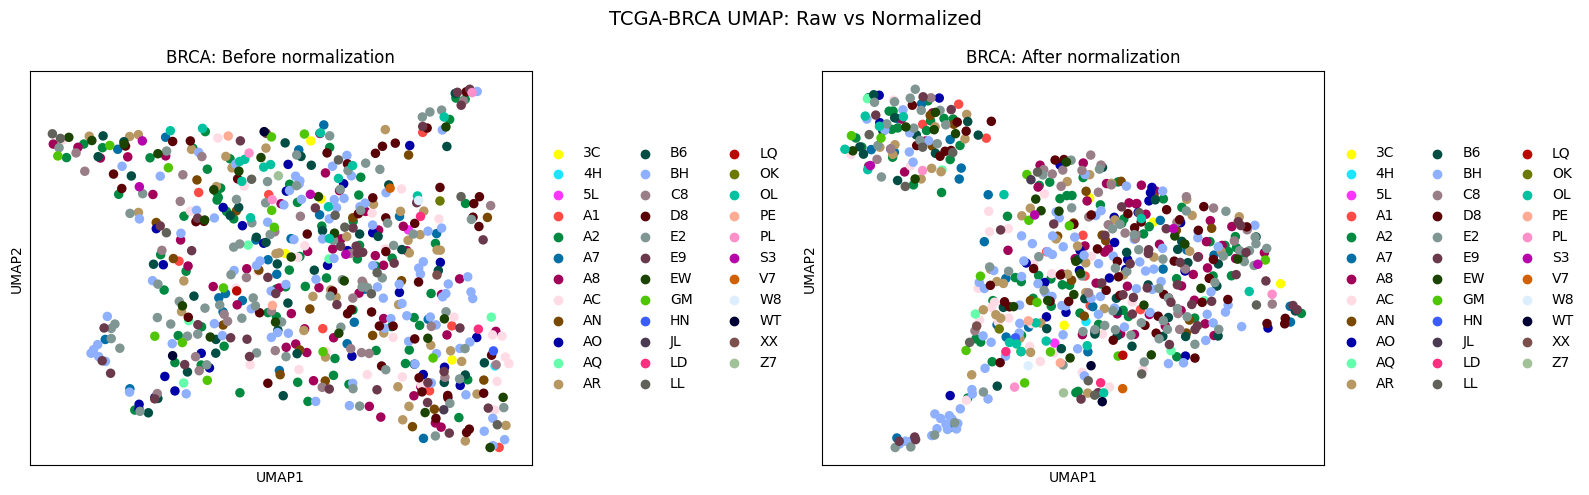

[INFO] Done: TCGA-BRCA normalized data saved.

[INFO] Processing TCGA-LUAD...


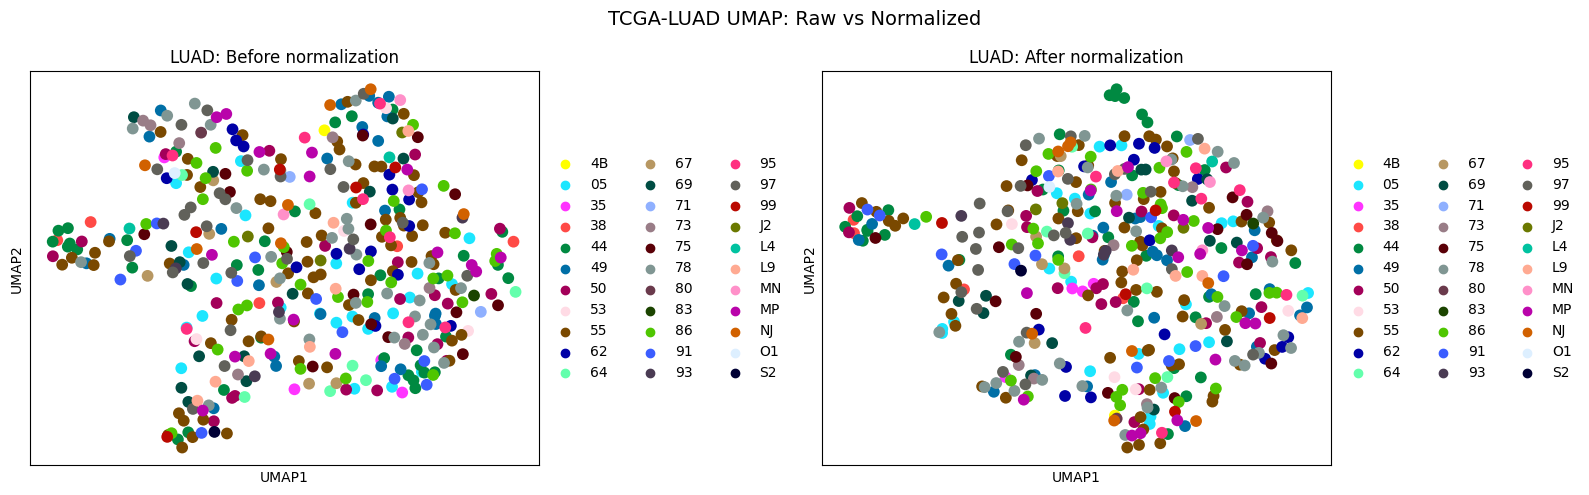

[INFO] Done: TCGA-LUAD normalized data saved.

[INFO] Processing TCGA-LUSC...


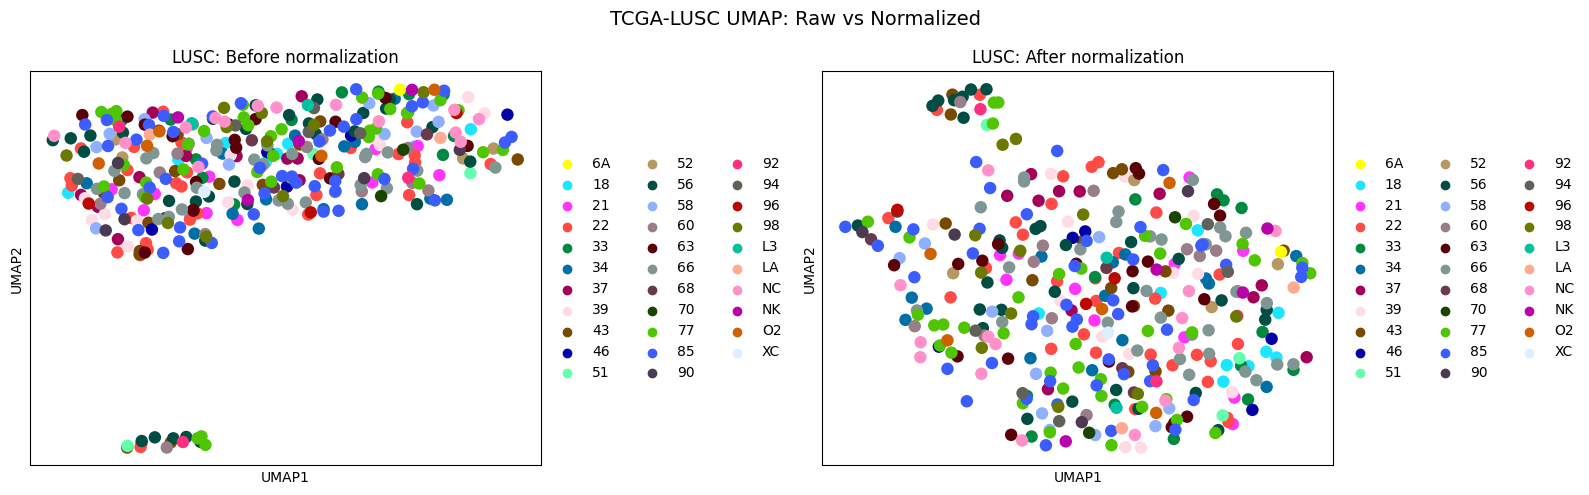

[INFO] Done: TCGA-LUSC normalized data saved.

✅ All TCGA datasets normalized and visualized.


In [6]:
import scanpy as sc
import matplotlib.pyplot as plt
import os

# --- Configuration ---
cancer_types = ["BRCA", "LUAD", "LUSC"]
input_dir = "../data/processed/tcga"
output_dir = "../data/processed/tcga_normalized"

os.makedirs(output_dir, exist_ok=True)

for cancer in cancer_types:
    print(f"\n[INFO] Processing TCGA-{cancer}...")

    # Load dataset
    input_path = os.path.join(input_dir, f"TCGA-{cancer}_final.h5ad")
    adata = sc.read_h5ad(input_path)

    # Backup raw
    adata_raw = adata.copy()

    # Step 1: UMAP before normalization (for comparison)
    sc.pp.pca(adata_raw)
    sc.pp.neighbors(adata_raw)
    sc.tl.umap(adata_raw)

    # Step 2: Normalize + log1p
    adata_norm = adata.copy()
    sc.pp.normalize_total(adata_norm, target_sum=1e6)
    sc.pp.log1p(adata_norm)

    # Step 3: UMAP after normalization
    sc.pp.pca(adata_norm)
    sc.pp.neighbors(adata_norm)
    sc.tl.umap(adata_norm)

    # Step 4: Show UMAPs side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    sc.pl.umap(adata_raw, color="batch", title=f"{cancer}: Before normalization", show=False, ax=axes[0])
    sc.pl.umap(adata_norm, color="batch", title=f"{cancer}: After normalization", show=False, ax=axes[1])
    plt.suptitle(f"TCGA-{cancer} UMAP: Raw vs Normalized", fontsize=14)
    plt.tight_layout()
    plt.show()

    # Step 5: Save normalized data
    adata_norm.write(os.path.join(output_dir, f"TCGA-{cancer}_normalized.h5ad"))
    print(f"[INFO] Done: TCGA-{cancer} normalized data saved.")

print("\n✅ All TCGA datasets normalized and visualized.")
